In [10]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, decomposition
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

[0.13501016 0.12577773 0.12031404]


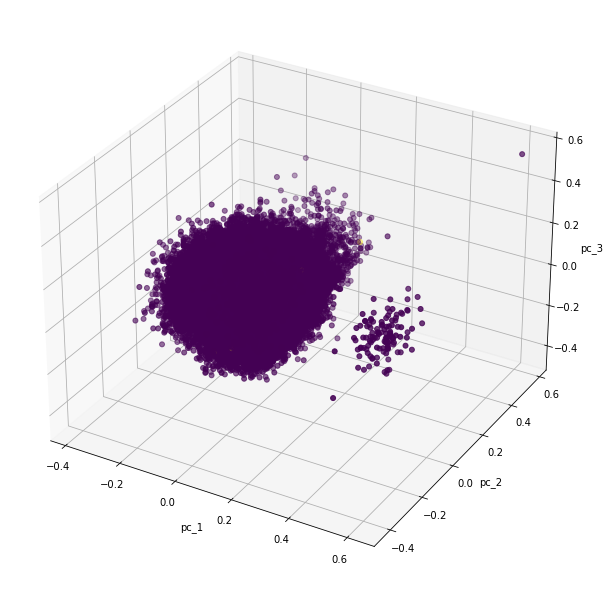

In [11]:
def show_pca_df(df):
	x = df[df.columns[1:30]].to_numpy()
	y = df[df.columns[30]].to_numpy()

	x = preprocessing.MinMaxScaler().fit_transform(x)
	pca = decomposition.PCA(n_components=3)
	pca_result = pca.fit_transform(x)
	print(pca.explained_variance_ratio_)

	pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
	pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

	ax = Axes3D(plt.figure(figsize=(8, 8)))
	ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
	ax.set_xlabel("pc_1")
	ax.set_ylabel("pc_2")
	ax.set_zlabel("pc_3")
	plt.show()

df = pd.read_csv('Desktop/ML Python files/CreditCardFraud-Autoencoder/creditcard.csv')

show_pca_df(df)

[0.20577961 0.14728955 0.09800454]


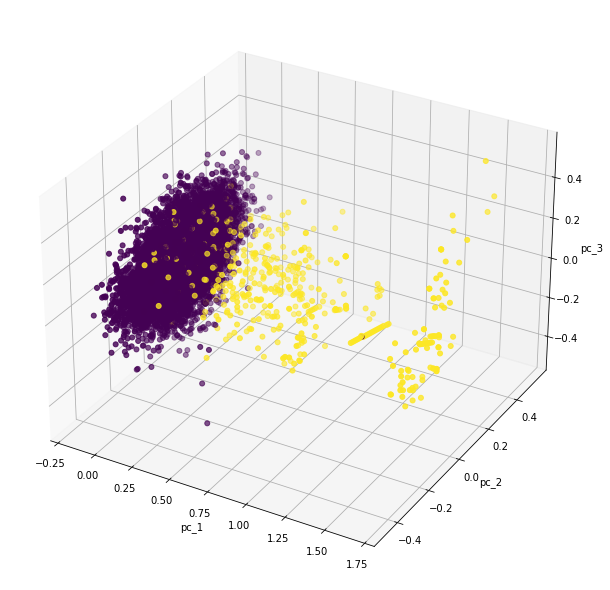

In [12]:
df_anomaly = df[df[df.columns[30]] > 0]
df_normal = df[df[df.columns[30]] == 0].sample(n=df_anomaly.size, random_state=1, axis='index')
df = pd.concat([ df_anomaly, df_normal])

show_pca_df(df)

Train on 227452 samples, validate on 56863 samples
Epoch 1/100
227452/227452 [==============================] - 10s 42us/sample - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/100
227452/227452 [==============================] - 9s 40us/sample - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 3/100
227452/227452 [==============================] - 9s 39us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.9540e-04 - val_mean_squared_error: 9.9540e-04
Epoch 4/100
227452/227452 [==============================] - 9s 39us/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.7258e-04 - val_mean_squared_error: 9.7258e-04
Epoch 5/100
227452/227452 [==============================] - 9s 39us/sample - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.5572e-04 - val_mean_squared_error: 9.5572e-04
Epoch 6/100
227452/227452 [==============================] - 9s 

Epoch 45/100
227452/227452 [==============================] - 10s 42us/sample - loss: 9.7110e-04 - mean_squared_error: 9.7111e-04 - val_loss: 9.3769e-04 - val_mean_squared_error: 9.3769e-04
Epoch 46/100
227452/227452 [==============================] - 9s 42us/sample - loss: 9.7006e-04 - mean_squared_error: 9.7006e-04 - val_loss: 8.9006e-04 - val_mean_squared_error: 8.9006e-04
Epoch 47/100
227452/227452 [==============================] - 10s 42us/sample - loss: 9.6849e-04 - mean_squared_error: 9.6849e-04 - val_loss: 8.8471e-04 - val_mean_squared_error: 8.8471e-04
Epoch 48/100
227452/227452 [==============================] - 9s 42us/sample - loss: 9.6779e-04 - mean_squared_error: 9.6779e-04 - val_loss: 8.8473e-04 - val_mean_squared_error: 8.8473e-04
Epoch 49/100
227452/227452 [==============================] - 9s 40us/sample - loss: 9.6738e-04 - mean_squared_error: 9.6738e-04 - val_loss: 8.8452e-04 - val_mean_squared_error: 8.8453e-04
Epoch 50/100
227452/227452 [=========================

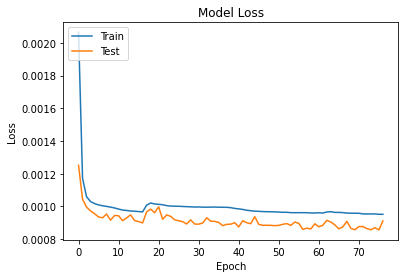

In [21]:
df = pd.read_csv('Desktop/ML Python files/CreditCardFraud-Autoencoder/creditcard.csv')

x = df[df.columns[1:30]].to_numpy()
y = df[df.columns[30]].to_numpy()

# prepare data
df = pd.concat([pd.DataFrame(x), pd.DataFrame({'anomaly': y})], axis=1)
normal_events = df[df['anomaly'] == 0]
abnormal_events = df[df['anomaly'] == 1]

normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

# scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# 80% percent of dataset is designated to training
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(scaled_data, test_size=0.2)

n_features = x.shape[1]

# model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
encoder = keras.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=10, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

decoder = keras.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=10, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=20, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

autoencoder = keras.Sequential([encoder, decoder])

from tensorflow.keras import losses, optimizers, metrics, callbacks

autoencoder.compile(
	loss=losses.MSE,
	optimizer=optimizers.Adam(),
	metrics=[metrics.mean_squared_error])

# train model
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, restore_best_weights=True)
history = autoencoder.fit(x=train_data, y=train_data, epochs=100, verbose=1, validation_data=[test_data, test_data], callbacks=[es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
train_predicted_x = autoencoder.predict(x=train_data)
train_events_mse = losses.mean_squared_error(train_data, train_predicted_x)
cut_off = np.percentile(train_events_mse, 95)

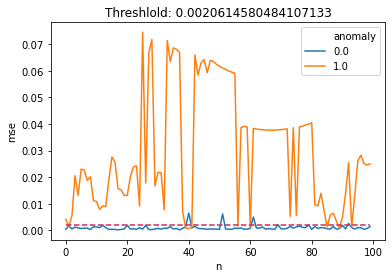

In [25]:
import seaborn as sns
plot_samples = 100
# normal event
real_x = test_data[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=real_x)
normal_events_mse = losses.mean_squared_error(real_x, predicted_x)
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})



# abnormal event
abnormal_x = scaler.transform(abnormal_events)[:plot_samples].reshape(plot_samples, n_features)
predicted_x = autoencoder.predict(x=abnormal_x)
abnormal_events_mse = losses.mean_squared_error(abnormal_x, predicted_x)
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df])
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

from matplotlib import lines
line = lines.Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()